In [2]:
#Import in all the libaries

%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [3]:
#DEBUG: See if files actually exist in the directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

In [6]:
#Store image size
IMAGE_SIZE = 224
img_dir = "../input/car-plate-detection/images" #img dir
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
files.sort() # Sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X = []
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [8]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [9]:
#DEBUG: Just checking if it works I have been here too long
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars147.xml")

[188, 141, 101, 104]

In [10]:
#DEBUG
y[0]

[187, 144, 101, 104]

In [12]:
#DEBUG Check X and Y shape
np.array(X).shape


(433, 224, 224, 3)

In [13]:
np.array(y).shape

(433, 4)

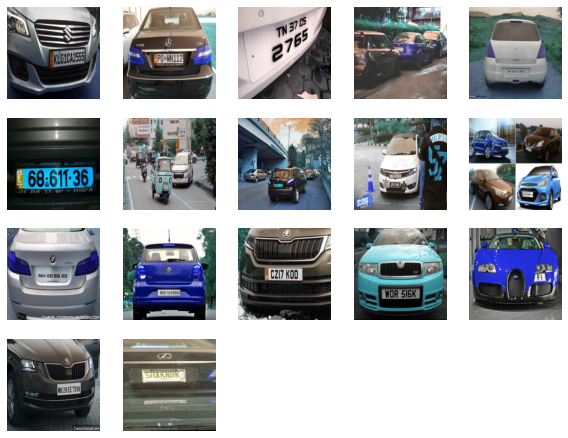

In [15]:
#DIsplay first 18 images of dataset
plt.figure(figsize=(10,20))
for i in range(0, 17):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i])

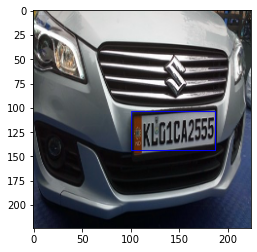

In [16]:
#Draw rectangle around license plate
#Example using only 1 image
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

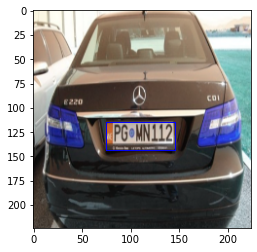

In [17]:
#TEST: Second image
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [18]:
#Prepare data for CNN
#Transforming in array
X = np.array(X)
y = np.array(y)

In [20]:
#Renormalisation
X = X / 255
y = y / 255

In [22]:
#Split data into training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [23]:
#SCARY: START Making Nureal network
#Imports 
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [26]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [27]:
model.save('my_model.h5', overwrite=True) 

ValueError: Weights for model sequential_2 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [28]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(train)

In [ ]:
#DETECTION
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

In [ ]:
 y_cnn = model.predict(X_test)

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)